In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(2, 16, bias=True)

        self.step2 = nn.ReLU()

        self.step3 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step4 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [25]:
df = pd.read_csv("four_directions.csv")

In [26]:
just_input = df.drop('last_matrix', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

df['last_matrix'] = df['last_matrix'] - 1

In [27]:
desired_output = torch.tensor(df['last_matrix'].tolist(), dtype=torch.float32).long()

C:\Users\16089\AppData\Local\Temp\ipykernel_13168\1858963403.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 15.605734825134277
Epoch [1/500], Loss: 1.4187
total loss: 15.593611121177673
Epoch [2/500], Loss: 1.4176
total loss: 15.584850907325745
Epoch [3/500], Loss: 1.4168
total loss: 15.57162868976593
Epoch [4/500], Loss: 1.4156
total loss: 15.544513821601868
Epoch [5/500], Loss: 1.4131
total loss: 15.302936673164368
Epoch [6/500], Loss: 1.3912
total loss: 14.610886931419373
Epoch [7/500], Loss: 1.3283
total loss: 14.152181506156921
Epoch [8/500], Loss: 1.2866
total loss: 13.991989135742188
Epoch [9/500], Loss: 1.2720
total loss: 13.724096179008484
Epoch [10/500], Loss: 1.2476
total loss: 13.480727314949036
Epoch [11/500], Loss: 1.2255
total loss: 13.392548561096191
Epoch [12/500], Loss: 1.2175
total loss: 13.323400259017944
Epoch [13/500], Loss: 1.2112
total loss: 13.23196566104889
Epoch [14/500], Loss: 1.2029
total loss: 13.178563594818115
Epoch [15/500], Loss: 1.1981
total loss: 13.12526524066925
Epoch [16/500], Loss: 1.1932
total loss: 13.062947154045105
Epoch [17/500], Loss:

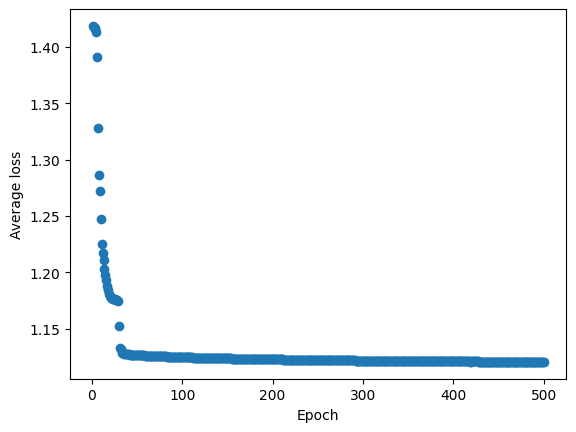

In [28]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.0005, viz_accuracy=True)

In [29]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [30]:
test_df = pd.read_csv("four_directions_test.csv")
test_df.columns = ['val1', 'val2', "last_matrix"]
just_input_test = test_df.drop('last_matrix', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
test_df['last_matrix'] = test_df['last_matrix'] - 1
desired_output = torch.tensor(test_df['last_matrix'].tolist(), dtype=torch.float32).long()

In [31]:
test_model(trained_model, input_data_test, desired_output)
# interesting, can get about 63% accuracy

C:\Users\16089\AppData\Local\Temp\ipykernel_13168\875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.6342685222625732

In [32]:
# plot a vizualization of what we would predict for a bunch of ordered pairs
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[i, j]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])

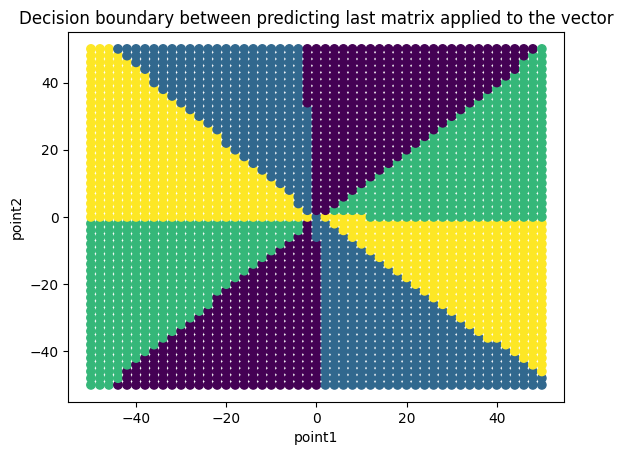

In [33]:
plt.scatter(confidence_df['x'], confidence_df['y'], c=confidence_df['confidence'])

plt.xlabel("point1")
plt.ylabel("point2")

plt.title("Decision boundary between predicting last matrix applied to the vector")

plt.show()

In [ ]:
# function to plot the first 1000 steps of the Euclidean algorithm on a given point or until we reach the y-axis or x-axis
def plot_to_y_axis(cur_input): 
    for _ in range(1, 1000):
        if min(cur_input @ np.array([1, 0]), cur_input @ np.array([0, 1])) == 0:
            break
        output = trained_model(cur_input)
        predicted_class = int(torch.tensor(output + 0.5, dtype=torch.int))
        if predicted_class==1:
            next_point = np.array([np.array(cur_input)[0] @ T])
        else: 
            next_point = np.array([np.array(cur_input)[0] @ U])

        # plot the direction of steps we took to get to the x-axis
        plt.scatter(x=cur_input[0][0], y=cur_input[0][1])

        plt.scatter(x=next_point[0][0], y=cur_input[0][1])

        plt.arrow(cur_input[0][0], cur_input[0][1], next_point[0][0]-cur_input[0][0], next_point[0][1]-cur_input[0][1], width=70, 
                  length_includes_head=True)
        
        cur_input = torch.tensor(next_point, dtype=torch.float32)
    
    plt.show()

In [ ]:
cur_input = np.random.randint(1, 10000, size=(1, 2))
cur_input = torch.tensor(cur_input, dtype=torch.float32)
plot_to_y_axis(cur_input)

NameError: name 'np' is not defined